In [ ]:
!pip install transformers

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-07-18 17:49:15--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolvendo lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Conectando-se a lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 3421431 (3,3M) [text/csv]
Salvando em: “AirlineTweets.csv”

AirlineTweets.csv   100%[===================>]   3,26M   228KB/s    em 15s     

2023-07-18 17:49:32 (227 KB/s) - “AirlineTweets.csv” salvo [3421431/3421431]



In [21]:
import time

class Timer(object):
    def __init__(self, name, verbose=True):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
         if self.verbose:
             print('[%s]' % self.name)
         print('Elapsed: %s' % (time.time() - self.tstart))


In [3]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


transformers.pipelines.text_classification.TextClassificationPipeline

In [5]:
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [6]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [7]:
classifier("This show was interesting")

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [8]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [9]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278430938720703}]

In [10]:
# Multiple inputs passed
classifier([
  "This course is just what I needed.",
  "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [11]:
import torch
torch.cuda.is_available()

True

In [12]:
torch.cuda.current_device()

0

In [22]:
# Multiple inputs passed in as a list
with Timer("Multiple inputs"):
  classifier([
    "This course is just what I needed.",
    "I can't understand any of this. Instructor kept telling me to meet the \
      prerequisites. What are prerequisites? Why does he keep saying that?"
  ])


[Multiple inputs]
Elapsed: 0.528062105178833


In [13]:
# Use the GPU
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [23]:
# Multiple inputs passed in as a list
with Timer("Multiple inputs"):
  classifier([
    "This course is just what I needed.",
    "I can't understand any of this. Instructor kept telling me to meet the \
      prerequisites. What are prerequisites? Why does he keep saying that?"
  ])


[Multiple inputs]
Elapsed: 0.009990215301513672


In [15]:
df_ = pd.read_csv("AirlineTweets.csv")

In [16]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [17]:
df = df_[['airline_sentiment', 'text']].copy()

<AxesSubplot: >

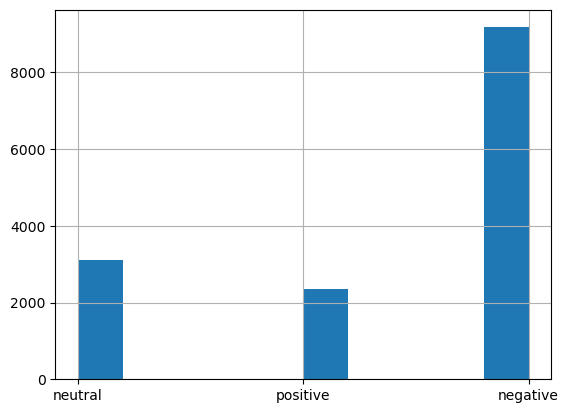

In [18]:
df['airline_sentiment'].hist()

In [24]:
df = df[df['airline_sentiment'] !=  'neutral']

<AxesSubplot: >

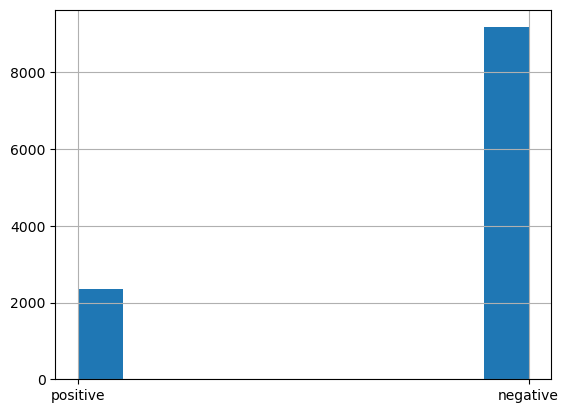

In [26]:
df['airline_sentiment'].hist()

In [28]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [30]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [36]:
texts = df['text'].tolist()
with Timer("predictions"):
    predictions = classifier(texts)

[predictions]
Elapsed: 31.941852807998657


In [37]:
predictions[:10]

[{'label': 'POSITIVE', 'score': 0.6070845127105713},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553211331367493},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957}]

In [73]:
probs = np.array([pred['score'] if pred['label'] == 'POSITIVE' else 1 - pred['score'] for pred in predictions])
probs[:10]

array([6.07084513e-01, 2.65508890e-03, 4.17649746e-04, 1.45749450e-02,
       9.55321133e-01, 9.82708812e-01, 9.99485135e-01, 9.99350965e-01,
       9.94082153e-01, 9.86313343e-01])

In [42]:
preds = np.array([1 if pred['label'] == 'POSITIVE' else 0 for pred in predictions])
preds[:10]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [43]:
print(f"Acc: {np.mean(df['target'] == preds)}")

Acc: 0.8898708950697514


In [61]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

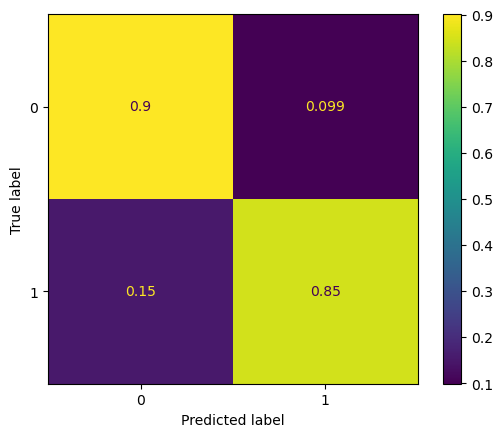

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [68]:
f1_score(df['target'], preds)

0.7587777566900741

In [70]:
f1_score(1- df['target'], 1-preds)

0.928647616908999

In [74]:
roc_auc_score(df["target"], probs)

0.9485933768463419

In [75]:
roc_auc_score(1-df["target"], 1-probs)

0.9485933768463419